# Tuning G* Calculations

Things to try:

- Using percentiles instead of aggregated burden score
- Using raw values instead of aggregared burden score
- Using a different weight that is distance based rather than border based?

In [3]:
# Load packages 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns         
import numpy as np
import os
import libpysal as lps 
from libpysal.weights import W 
from esda.getisord import G_Local
from functions import state_gstar
import pprint
from functools import reduce

# Remove max columns
pd.set_option('display.max_columns', None)

In [4]:
# Import data
base_dir = "/capstone/justice40"
# base_dir = "~/MEDS/justice40/data-exploration"

# Complete 2.0 USA file
usa_v2 = pd.read_csv(os.path.join(base_dir, "data", "usa_v2.csv"))

# 2.0 communities files (from current CEJST website)
comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))

# Version 2.0 shapefile data
v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "2.0-codebook.csv"))
v2_geo = gpd.read_file(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "usa", "usa.shp"))

/tmp/ipykernel_951767/2040895413.py:6: DtypeWarning: Columns (1,2,3,79,80,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  usa_v2 = pd.read_csv(os.path.join(base_dir, "data", "usa_v2.csv"))
/tmp/ipykernel_951767/2040895413.py:9: DtypeWarning: Columns (18,29,73,75,88,134) have mixed types. Specify dtype option on import or set low_memory=False.
  comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))


In [5]:
usa_v2 = usa_v2.select_dtypes(exclude=['bool'])
usa_v2.head()

,GEOID10_TRACT,Does the tract have at least 35 acres in it?,Contains agricultural value,Names of Tribal areas within Census tract,Housing burden (percent),Share of homes with no kitchen or indoor plumbing (percent),Total population,Estimated population count of off-campus university students <200% FPL,Median household income (% of state median household income),Current asthma among adults aged greater than or equal to 18 years,Coronary heart disease among adults aged greater than or equal to 18 years,Cancer (excluding skin cancer) among adults aged greater than or equal to 18 years,Current lack of health insurance among adults aged 18-64 years,Diagnosed diabetes among adults aged greater than or equal to 18 years,Physical health not good for greater than or equal to 14 days among adults aged greater than or equal to 18 years,Percent of individuals < 100% Federal Poverty Line,Percent of individuals < 150% Federal Poverty Line,Percent of individuals below 200% Federal Poverty Line,Area Median Income (State or metropolitan),Median household income in the past 12 months,Energy burden,FEMA Risk Index Expected Annual Loss Score,Urban Heuristic Flag,Air toxics cancer risk,Respiratory hazard index,Diesel particulate matter exposure,PM2.5 in the air,Ozone,Traffic proximity and volume,Proximity to Risk Management Plan (RMP) facilities,Proximity to hazardous waste sites,Proximity to NPL sites,Wastewater discharge,Percent pre-1960s housing (lead paint indicator),Individuals under 5 years old,Individuals over 64 years old,Linguistic isolation (percent),Percent of households in linguistic isolation,Poverty (Less than 200% of federal poverty line),Percent individuals age 25 or over with less than high school degree,Unemployment (percent),Median value ($) of owner-occupied housing units,Percent enrollment in college or graduate school,Percent of population not currently enrolled in college or graduate school,Expected building loss rate (Natural Hazards Risk Index),Expected agricultural loss rate (Natural Hazards Risk Index),Expected population loss rate (Natural Hazards Risk Index),Percent individuals age 25 or over with less than high school degree in 2009,Percentage households below 100% of federal poverty line in 2009,Percentage households below 200% of federal poverty line in 2009,"Percentage households below 200% of federal poverty line in 2009, adjusted and imputed",Unemployment (percent) in 2009,Unemployment (percent) in 2010,Percent of individuals less than 100% Federal Poverty Line in 2010,Total population in 2009,Leaky underground storage tanks,DOT Travel Barriers Score,Share of properties at risk of flood in 30 years,Share of properties at risk of fire in 30 years,Share of the tract's land area that is covered by impervious surface or cropland as a percent,"Percent of individuals below 200% Federal Poverty Line, imputed and adjusted",Percent Black or African American,Percent American Indian / Alaska Native,Percent Asian,Percent Native Hawaiian or Pacific,Percent two or more races,Percent White,Percent Hispanic or Latino,Percent other races,Percent age under 10,Percent age 10 to 64,Percent age over 64,Percent of the Census tract that is within Tribal areas,Number of Tribal areas within Census tract for Alaska,Number of Tribal areas within Census tract,"Percent of the Census tract that is within Tribal areas, for display",Median household income as a percent of area median income,Life expectancy (years),Median household income as a percent of territory median income in 2009,Is there at least one abandoned mine in this census tract?,Income data has been estimated based on neighbor income,Is there at least one Formerly Used Defense Site (FUDS) in the tract?,Tract-level redlining score meets or exceeds 3.25,Identified as disadvantaged due to tribal overlap,Housing burden (percent) (percentile),Share of homes with no kitchen or indoor plumbing (percent) (percentile),Total population (percentile),Estimated population count of off-campus u

In [ ]:
v2_geo.head()
# geometry, GEOID10

,GEOID10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,EPLR_PFS,HBF_PFS,LLEF_PFS,LIF_PFS,LMI_PFS,PM25F_PFS,HSEF,P100_PFS,P200_I_PFS,AJDLI_ET,LPF_PFS,KP_PFS,NPL_PFS,RMP_PFS,TSDF_PFS,TPF,TF_PFS,UF_PFS,WF_PFS,UST_PFS,N_WTR,N_WKFC,N_CLT,N_ENY,N_TRN,N_HSG,N_PLN,N_HLTH,SN_C,SN_C_V10,SN_GRAND,SN_T,DLI,ALI,PLHSE,LMILHSE,ULHSE,EPL_ET,EAL_ET,EBL_ET,EB_ET,PM25_ET,DS_ET,TP_ET,LPP_ET,HRS_ET,KP_ET,HB_ET,RMP_ET,NPL_ET,TSDF_ET,WD_ET,UST_ET,DB_ET,A_ET,HD_ET,LLE_ET,UN_ET,LISO_ET,POV_ET,LMI_ET,IA_LMI_ET,IA_UN_ET,IA_POV_ET,TC,CC,IAULHSE,IAPLHSE,IALMILHSE,IALMIL_78,IAPLHS_79,IAULHS_80,LHE,IALHE,IAHSEF,N_CLT_EOMI,N_ENY_EOMI,N_TRN_EOMI,N_HSG_EOMI,N_PLN_EOMI,N_WTR_EOMI,N_HLTH_90,N_WKFC_91,FPL200S,FPL200P,N_WKFC_94,TD_ET,TD_PFS,FLD_PFS,WFR_PFS,FLD_ET,WFR_ET,ADJ_ET,IS_PFS,IS_ET,AML_ET,FUDS_RAW,FUDS_ET,IMP_FLG,DM_B,DM_AI,DM_A,DM_HI,DM_T,DM_W,DM_H,DM_O,AGE_10,AGE_MIDDLE,AGE_OLD,TA_COU_119,TA_COUNT_C,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,geometry
0,01073001100,Alabama,Jefferson County,0.96,0.85,0.72,0.84,0.86,0.21,0.78,0.61,0.64,0.97,0.12,0.82,0.82,0.08,0.62,0.65,1,0.39,0.21,0.75,0.90,0.48,4781.0,0.39,0.02,0.96,0.52,1,0,0,0,0,1,1,1,1,0,0,None,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,5,4.0,0,0,0,NaN,NaN,NaN,0,0,NaN,0,0,0,1,1,1,1,0,1,NaN,0,0,0.45,0.49,0.84,0,0,0,0.26,0,0,None,0,0,0.96,0.01,0.0,0.0,0.00,0.01,0.00,0.00,0.13,0.66,0.20,NaN,NaN,NaN,NaN,Nation,21,"POLYGON ((-86.88244 33.55233, -86.88187 33.552..."
1,01073001400,Alabama,Jefferson County,0.98,0.83,0.92,0.93,0.97,0.08,0.91,0.55,0.34,0.96,0.58,0.83,0.83,0.17,0.86,0.78,1,0.84,0.50,0.86,0.87,0.80,1946.0,0.95,0.90,0.84,0.64,0,1,1,1,1,1,0,1,1,1,0,None,1,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,9,6.0,0,0,0,NaN,NaN,NaN,1,0,NaN,1,1,1,1,0,0,1,1,1,NaN,1,0,0.37,0.88,0.33,0,0,1,0.55,0,0,None,0,0,0.91,0.00,0.0,0.0,0.00,0.00,0.06,0.07,0.08,0.72,0.18,NaN,NaN,NaN,NaN,Nation,21,"POLYGON ((-86.84088 33.52759, -86.83782 33.528..."
2,01073002000,Alabama,Jefferson County,0.98,0.97,0.94,0.76,0.93,0.08,0.64,0.63,0.89,0.95,0.54,0.93,0.81,0.23,0.98,0.96,1,0.82,0.59,0.75,0.37,0.73,4080.0,0.61,0.94,0.83,0.81,0,1,0,1,0,0,0,1,1,1,0,None,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,0,0,0,8,3.0,0,0,0,NaN,NaN,NaN,1,0,NaN,0,1,0,0,0,0,1,1,1,NaN,1,0,0.52,0.84,0.33,0,0,1,0.23,0,0,None,0,0,0.63,0.00,0.0,0.0,0.00,0.27,0.07,0.02,0.15,0.71,0.12,NaN,NaN,NaN,NaN,Nation,21,"POLYGON ((-86.7139 33.5393, -86.71435 33.53912..."
3,01073003802,Alabama,Jefferson County,0.95,0.91,0.62,0.79,0.97,0.07,0.90,0.55,0.87,0.86,0.12,0.79,0.83,0.14,0.73,0.85,1,0.83,0.94,0.60,0.74,0.68,5291.0,0.49,0.87,0.16,0.85,0,0,1,1,0,1,0,1,1,1,0,None,1,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,6,4.0,0,0,0,NaN,NaN,NaN,1,0,NaN,1,1,0,1,0,0,1,0,1,NaN,1,0,0.75,0.82,0.33,0,0,1,0.49,0,0,None,0,0,0.97,0.00,0.0,0.0,0.00,0.01,0.00,0.00,0.14,0.72,0.13,NaN,NaN,NaN,NaN,Nation,21,"POLYGON ((-86.90317 33.47177, -86.90284 33.472..."
4,01073004000,Alabama,Jefferson County,0.99,0.96,0.96,0.86,0.98,NaN,0.95,0.55,0.92,0.99,0.71,0.98,0.84,0.17,0.95,0.96,1,0.67,0.67,0.71,0.86,0.73,2533.0,0.49,0.98,0.19,0.66,0,1,1,1,0,1,0,1,1,1,0,None,1,1,1,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,1,1,0,1,1,0,0,0,11,5.0,0,0,0,NaN,NaN,NaN,1,0,NaN,1,1,0,1,0,0,1,1,1,NaN,1,0,0.33,0.80,0.33,0,0,1,0.68,0,0,None,0,0,0.85,0.00,0.0,0.0,0.04,0.06,0.06,0.00,0.06,0.68,0.24,NaN,NaN,NaN,NaN,Nation,21,"POLYGON ((-86.85463 33.48754, -86.85554 33.486..."


In [6]:
# my_list = usa_v2.columns.to_list()
# pprint.pprint(my_list, compact=False) 

In [ ]:
# Climate Change
cc = usa_v2[['Expected agricultural loss rate (Natural Hazards Risk Index) (percentile)', 
            'Expected building loss rate (Natural Hazards Risk Index) (percentile)', 
            'Expected population loss rate (Natural Hazards Risk Index) (percentile)', 
            'Share of properties at risk of flood in 30 years (percentile)', 
            'Share of properties at risk of fire in 30 years (percentile)',
            'GEOID10_TRACT']]
cc =cc.rename(columns={
    'Expected agricultural loss rate (Natural Hazards Risk Index) (percentile)':'ag_loss', 
    'Expected building loss rate (Natural Hazards Risk Index) (percentile)':'building_loss', 
    'Expected population loss rate (Natural Hazards Risk Index) (percentile)':'population_loss', 
    'Share of properties at risk of flood in 30 years (percentile)':'flood_risk', 
    'Share of properties at risk of fire in 30 years (percentile)':'fire_risk'
})
cc['cc_mean'] = cc[['ag_loss', 'building_loss', 'population_loss', 'flood_risk', 'fire_risk']].mean(axis=1)

cc.head()

,ag_loss,building_loss,population_loss,flood_risk,fire_risk,GEOID10_TRACT,cc_mean
0,0.215315,0.784638,0.614474,0.497477,0.841147,1073001100,0.590610
1,0.086538,0.916615,0.559042,0.885039,0.336647,1073001400,0.556776
2,0.083697,0.648245,0.634793,0.847378,0.336647,1073002000,0.510152
3,0.072682,0.900051,0.553442,0.826693,0.336647,1073003802,0.537903
4,NaN,0.951725,0.555440,0.808244,0.336647,1073004000,0.663014


In [ ]:
# Energy
energy = usa_v2[['Energy burden (percentile)', 'PM2.5 in the air (percentile)', 'GEOID10_TRACT']]
energy = energy.rename(columns={
    'Energy burden (percentile)':'energy_burden', 
    'PM2.5 in the air (percentile)':'pm_25'
    })
energy['energy_mean'] = energy[['energy_burden', 'pm_25']].mean(axis=1)

energy.head()


,energy_burden,pm_25,GEOID10_TRACT,energy_mean
0,0.864990,0.825669,1073001100,0.845330
1,0.970847,0.839065,1073001400,0.904956
2,0.932047,0.810017,1073002000,0.871032
3,0.977915,0.830914,1073003802,0.904414
4,0.989683,0.840601,1073004000,0.915142


In [ ]:
# Housing
housing = usa_v2[['Housing burden (percent) (percentile)', 
                'Share of homes with no kitchen or indoor plumbing (percent) (percentile)', 
                'Percent pre-1960s housing (lead paint indicator) (percentile)',
                'GEOID10_TRACT']]
housing = housing.rename(columns={
    'Housing burden (percent) (percentile)':'housing_burden',
    'Share of homes with no kitchen or indoor plumbing (percent) (percentile)':'no_plumbing', 
    'Percent pre-1960s housing (lead paint indicator) (percentile)':'lead_paint'
})
housing['housing_mean'] = housing[['housing_burden', 'no_plumbing', 'lead_paint']].mean(axis=1)

housing.head()

,housing_burden,no_plumbing,lead_paint,GEOID10_TRACT,housing_mean
0,0.646637,0.215989,0.397913,1073001100,0.420180
1,0.342058,0.505139,0.846261,1073001400,0.564486
2,0.899590,0.591729,0.827268,1073002000,0.772862
3,0.875027,0.943543,0.832270,1073003802,0.883613
4,0.928449,0.673872,0.671988,1073004000,0.758103


In [ ]:
# Health
health = usa_v2[['Current asthma among adults aged greater than or equal to 18 years (percentile)', 
                'Diagnosed diabetes among adults aged greater than or equal to 18 years (percentile)', 
                'Coronary heart disease among adults aged greater than or equal to 18 years (percentile)',
                'Low life expectancy (percentile)',
                'GEOID10_TRACT']]
health = health.rename(columns={
    'Current asthma among adults aged greater than or equal to 18 years (percentile)':'asthma', 
    'Diagnosed diabetes among adults aged greater than or equal to 18 years (percentile)':'diabetes', 
    'Coronary heart disease among adults aged greater than or equal to 18 years (percentile)':'heart_disease',
    'Low life expectancy (percentile)':'low_life_expectancy'
})
health['health_mean'] = health[['asthma', 'diabetes', 'heart_disease', 'low_life_expectancy']].mean(axis=1)

health.head()

,asthma,diabetes,heart_disease,low_life_expectancy,GEOID10_TRACT,health_mean
0,0.850988,0.965376,0.726480,0.970729,1073001100,0.878393
1,0.838593,0.987805,0.921800,0.960289,1073001400,0.927122
2,0.973547,0.989803,0.942280,0.954734,1073002000,0.965091
3,0.919545,0.957298,0.626278,0.866511,1073003802,0.842408
4,0.963833,0.996366,0.961202,0.990238,1073004000,0.977910


In [ ]:
# Legacy Pollution
lp = usa_v2[['Is there at least one abandoned mine in this census tract?', 
            'Is there at least one Formerly Used Defense Site (FUDS) in the tract?', 
            'Proximity to hazardous waste sites (percentile)', 
            'Proximity to NPL sites (percentile)', 
            'Proximity to Risk Management Plan (RMP) facilities (percentile)',
            'GEOID10_TRACT']]
lp = lp.rename(columns={
    'Is there at least one abandoned mine in this census tract?':'abandoned_mines', 
    'Is there at least one Formerly Used Defense Site (FUDS) in the tract?':'defense_site', 
    'Proximity to hazardous waste sites (percentile)':'hazardous_waste', 
    'Proximity to NPL sites (percentile)':'npl_sites', 
    'Proximity to Risk Management Plan (RMP) facilities (percentile)':'rmp_facilites'
})
lp['lp_mean'] = lp[['abandoned_mines', 'defense_site', 'hazardous_waste', 'npl_sites', 'rmp_facilites']].mean(axis=1)

lp.head()

,abandoned_mines,defense_site,hazardous_waste,npl_sites,rmp_facilites,GEOID10_TRACT,lp_mean
0,NaN,NaN,0.481940,0.753109,0.900738,1073001100,0.711929
1,NaN,NaN,0.800192,0.865335,0.879948,1073001400,0.848491
2,NaN,NaN,0.736861,0.753366,0.378880,1073002000,0.623035
3,NaN,NaN,0.685330,0.606602,0.745918,1073003802,0.679283
4,NaN,NaN,0.731102,0.716462,0.860860,1073004000,0.769475


In [ ]:
# Transportation
transport = usa_v2[['Diesel particulate matter exposure (percentile)', 
                    'DOT Travel Barriers Score (percentile)', 
                    'Traffic proximity and volume (percentile)',
                    'GEOID10_TRACT']]
transport = transport.rename(columns={
    'Diesel particulate matter exposure (percentile)':'diesel_pm', 
    'DOT Travel Barriers Score (percentile)':'travel_barriers', 
    'Traffic proximity and volume (percentile)':'traffic_proximity'
})
transport['transport_mean'] = transport[['diesel_pm', 'travel_barriers', 'traffic_proximity']].mean(axis=1)

transport.head()

,diesel_pm,travel_barriers,traffic_proximity,GEOID10_TRACT,transport_mean
0,0.840725,0.453320,0.391992,1073001100,0.562012
1,0.938048,0.372790,0.956325,1073001400,0.755721
2,0.765093,0.525417,0.617938,1073002000,0.636149
3,0.799755,0.751179,0.497279,1073003802,0.682737
4,0.866544,0.338863,0.490575,1073004000,0.565327


In [ ]:
# Waste and Wastewater
ww = usa_v2[['Leaky underground storage tanks (percentile)', 'Wastewater discharge (percentile)', 'GEOID10_TRACT']]
ww =ww.rename(columns={
    'Leaky underground storage tanks (percentile)':'leaky_storage_tanks', 
    'Wastewater discharge (percentile)':'wastewater_discharge'
})
ww['ww_mean'] = ww[['leaky_storage_tanks', 'wastewater_discharge']].mean(axis=1)

ww.head()

,leaky_storage_tanks,wastewater_discharge,GEOID10_TRACT,ww_mean
0,0.521020,0.961966,1073001100,0.741493
1,0.641735,0.843141,1073001400,0.742438
2,0.817535,0.831253,1073002000,0.824394
3,0.850627,0.163562,1073003802,0.507095
4,0.667514,0.191097,1073004000,0.429305


In [ ]:
# Workforce Development
wd = usa_v2[['Linguistic isolation (percent) (percentile)', 
            'Low median household income as a percent of area median income (percentile)', 
            'Poverty (Less than 200% of federal poverty line) (percentile)', 
            'Unemployment (percent) (percentile)',
            'GEOID10_TRACT']]
wd = wd.rename(columns={
    'Linguistic isolation (percent) (percentile)':'ling_isolation', 
    'Low median household income as a percent of area median income (percentile)':'low_income', 
    'Poverty (Less than 200% of federal poverty line) (percentile)':'poverty', 
    'Unemployment (percent) (percentile)':'unemployment'
})
wd['wd_mean'] = wd[['ling_isolation', 'low_income', 'poverty', 'unemployment']].mean(axis=1)

wd.head()

,ling_isolation,low_income,poverty,unemployment,GEOID10_TRACT,wd_mean
0,0.128771,0.821814,0.634760,0.029797,1073001100,0.403785
1,0.586708,0.836427,0.791676,0.906740,1073001400,0.780388
2,0.541384,0.938839,0.969030,0.941376,1073002000,0.847657
3,0.128771,0.794525,0.840408,0.877831,1073003802,0.660384
4,0.714412,0.985994,0.961596,0.984514,1073004000,0.911629


In [ ]:
# Concat without ids
# dfs = [cc, health, housing, energy, lp, transport, ww, wd]
# complete = pd.concat(dfs, axis=1)
# complete.head()

In [ ]:
# Merge using tract ID
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['GEOID10_TRACT'],
                                            how='outer'), dfs)
df_merged = df_merged.set_index('GEOID10_TRACT')
df_merged.head()

,ag_loss,building_loss,population_loss,flood_risk,fire_risk,GEOID10_TRACT,asthma,diabetes,heart_disease,low_life_expectancy,housing_burden,no_plumbing,lead_paint,energy_burden,pm_25,abandoned_mines,defense_site,hazardous_waste,npl_sites,rmp_facilites,diesel_pm,travel_barriers,traffic_proximity,leaky_storage_tanks,wastewater_discharge,ling_isolation,low_income,poverty,unemployment
0,0.450258,0.668373,0.761497,0.877485,0.843134,1001020100,0.577048,0.608124,0.592558,0.899312,0.507427,0.523720,0.413053,0.495717,0.672774,NaN,NaN,0.425949,0.529699,0.114632,0.337571,0.709842,0.156774,0.260747,NaN,0.128771,0.299915,0.447902,0.226883
1,0.211633,0.691953,0.653784,0.897761,0.773397,1001020200,0.824563,0.838778,0.498827,0.656848,0.566584,0.215989,0.438494,0.062206,0.681659,NaN,NaN,0.509746,0.557938,0.124081,0.379372,0.881755,0.365568,0.576903,NaN,0.128771,0.618755,0.730183,0.442223
2,0.399996,0.542573,0.592987,0.482328,0.787609,1001020300,0.658555,0.661066,0.609112,NaN,0.468949,0.215989,0.220572,0.681637,0.688689,NaN,NaN,0.598370,0.571023,0.123770,0.454036,0.508855,0.377938,0.523805,NaN,0.128771,0.381057,0.484116,0.322317
3,0.435171,0.558642,0.624914,0.618738,0.782760,1001020400,0.273214,0.551029,0.660930,0.779033,0.281915,0.658086,0.315197,0.639539,0.695720,NaN,False,0.696848,0.606818,0.134098,0.553457,0.173959,0.643604,0.657673,NaN,0.581549,0.308292,0.327336,0.275987
4,0.539677,0.554831,0.611031,0.256225,0.732097,1001020500,0.378536,0.344979,0.315120,0.410042,0.461960,0.957054,0.019263,0.386097,0.699262,NaN,NaN,0.561777,0.642465,0.139883,0.616609,0.062268,0.434797,0.550773,0.103215,0.540248,0.222737,0.299178,0.263870


In [28]:
# geometry, GEOID10
geo_join = v2_geo[['GEOID10', 'geometry']].rename(columns={'GEOID10':'GEOID10_TRACT'})
geo_join['GEOID10_TRACT'] =geo_join['GEOID10_TRACT'].astype('int64')

In [29]:
geo_join.dtypes

GEOID10_TRACT       int64
geometry         geometry
dtype: object

In [30]:
cc = pd.merge(cc, geo_join, how='outer', on='GEOID10_TRACT')

cc.head()

,ag_loss,building_loss,population_loss,flood_risk,fire_risk,GEOID10_TRACT,cc_mean,geometry
0,0.450258,0.668373,0.761497,0.877485,0.843134,1001020100,0.720149,"POLYGON ((-86.48196 32.49876, -86.48189 32.498..."
1,0.211633,0.691953,0.653784,0.897761,0.773397,1001020200,0.645706,"POLYGON ((-86.46828 32.4737, -86.468 32.47371,..."
2,0.399996,0.542573,0.592987,0.482328,0.787609,1001020300,0.561099,"POLYGON ((-86.46538 32.47372, -86.46597 32.473..."
3,0.435171,0.558642,0.624914,0.618738,0.782760,1001020400,0.604045,"POLYGON ((-86.43807 32.45349, -86.43812 32.453..."
4,0.539677,0.554831,0.611031,0.256225,0.732097,1001020500,0.538772,"POLYGON ((-86.4118 32.47416, -86.4118 32.47369..."


In [34]:
cc =gpd.GeoDataFrame(cc)
type(cc)

geopandas.geodataframe.GeoDataFrame

In [35]:
# Drop geometry NAs
cc_clean = cc[(cc.geometry.type == 'Polygon') |( cc.geometry.type == 'MultiPolygon')]

# Confirm our geometries are correct
cc_clean.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [36]:
# Create weights using Queen method 
w = lps.weights.Queen(cc_clean['geometry'])

# Run the Getis Ord test for burdens
g_local = G_Local(cc_clean['cc_mean'], w, transform='R') # Set transform=R because the queen weights are row-standardized weights.

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
 There are 19 islands with ids: 10022, 10463, 11538, 16613, 20502, 20518, 20549, 20554, 32755, 33437, 58373, 58520, 72746, 72747, 72748, 72813, 72814, 72833, 73155.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 10022, ' is an island (no neighbors)')
('WARNING: ', 10463, ' is an island (no neighbors)')
('WARNING: ', 11538, ' is an island (no neighbors)')
('WARNING: ', 16613, ' is an island (no neighbors)')
('WARNING: ', 20502, ' is an island (no neighbors)')
('WARNING: ', 20518, ' is an island (no neighbors)')
('WARNING: ', 20549, ' is an island (no neighbors)')
('WARNING: ', 20554, ' is an island (no neighbors)')
('WARNING: ', 32755, ' is an island (no neighbors)')
('WARNING: ', 33437, ' is an island (no neighbors)')
('WARNING: ', 58373, ' is an island (no neighbors)')
('WARNING: ', 58520, ' is an island (no neighbors)')
('WARNING: ', 72746, ' is an island (no neighbors)')
('WARNING: ', 72747, ' is an island (no neighbors)')
('WARNING: ', 72748, ' is an island (no neighbors)')
('WARNING: ', 72813, ' is an island (no neighbors)')
('WARNING: ', 72814, ' is an island (no neighbors)')
('WARNING: ', 72833, ' is an island (no neighbors)')
('WARNING: ', 73155, ' is an island (no neighb

In [37]:
# Add statistics to to a new df
results = cc_clean.copy()
# results['original_g_star'] = g_local.Gs # I think this is the old school g score we're not actually going to use
results['standardized_gstar'] = g_local.Zs 
results['p_norm'] = g_local.p_norm # p-value assuming normal distribution

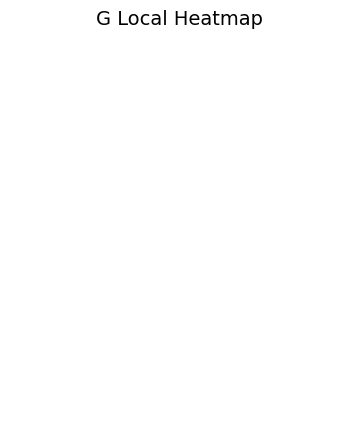

In [39]:
# Define your custom bins (values for standardized_g_star)
bins = [-3, -2.58, -1.96, 0, 1.96, 2.58, 3]

# Create a colormap
cmap = plt.get_cmap('RdBu_r')

# Create a norm to map standardized_g_star values to the bins
norm = colors.BoundaryNorm(boundaries=bins, ncolors=cmap.N)

# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title('G Local Heatmap',
            fontsize=14)

# Plot NY state and color by number of spills 
plot = results.plot(ax=ax,
                column='standardized_gstar',
                cmap=cmap,
                norm=norm,
                legend=False)
                # legend_kwds={
                #     'label':'Number of Burdens'
                # })


# Get the colorbar from the plot
# cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax)

# # Modify the colorbar tick labels
# cbar.set_ticklabels([' ', '99th+', '95th', 'low', '95th', '99th+', ' ']) 

plt.show()